In [ ]:
# default_exp timeseries.core

# timeseries.core

> API details.

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
#export
import pandas as pd
from fastai.data.external import *
from fastcore.all import *
from pathlib import PosixPath
from fastcore.test import *
from fastai.tabular.all import *
import fastai
from fastai.tabular.core import _maybe_expand
from fastrenewables.tabular.core import *
from fastrenewables.utils import *

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
files = glob.glob('../data/*.h5')
dfs = read_files(files)

In [ ]:
#hide
def get_data(splits=None):
    return TabularRenewables(pd.concat(dfs), 
                       pre_process=FilterInconsistentSamplesPerDay, 
                       splits=splits,
                       cat_names="TaskID",
                       cont_names = [ 'WindSpeed58m', 'WindSpeed60m'],
                       y_names="PowerGeneration",
                       procs=Categorify,
                      )

In [ ]:
#hide
def get_test_df():
    np.random.seed(123)
    cont1, cont2 = np.arange(0,48, 0.5), np.arange(0,48, 0.5)[::-1]
    conts = np.concatenate([cont1.reshape(-1,1), cont2.reshape(-1,1)], axis=1)
    cat = np.random.randint(0,5, 96)
    task_ids = np.zeros(96)
    task_ids[-16:] = 1
    y = np.random.randn((96))
    df = pd.DataFrame(conts, columns=["x1", "x2"])
    df["cat"] = cat
    df["TID"] = task_ids
    df["y"] = y
    df.index =pd.date_range("1/1/2021", freq="3H", periods=96)
    return df

def get_test_tabular(cat_names="cat", target="y", y_block=RegressionBlock()):
    df = get_test_df()
    
    return TabularRenewables(df.sample(frac=1), cat_names=cat_names, y_names=target, 
                             cont_names=["x1", "x2"], group_id="TID", y_block=y_block)

The following example shows a dataframe that we want to convert to a timeseries representation. We are intereseted in samples, where each sample contains a whole day. In this example a day consist of 8 samples.

In [ ]:
df = get_test_df()
df.sort_index().head(9)

,x1,x2,cat,TID,y
2021-01-01 00:00:00,0.0,47.5,2,0.0,1.267518
2021-01-01 03:00:00,0.5,47.0,4,0.0,2.107840
2021-01-01 06:00:00,1.0,46.5,2,0.0,-0.236089
2021-01-01 09:00:00,1.5,46.0,1,0.0,-0.232082
2021-01-01 12:00:00,2.0,45.5,3,0.0,-1.078139
2021-01-01 15:00:00,2.5,45.0,2,0.0,1.163185
2021-01-01 18:00:00,3.0,44.5,3,0.0,0.522490
2021-01-01 21:00:00,3.5,44.0,1,0.0,1.844365
2021-01-02 00:00:00,4.0,43.5,1,0.0,0.695564


The following function takes a dataframe as input and converts the specified columns into the required timeseries representation.

In [ ]:
#export
def _reshape_dataframe_to_timeseries_representation(df, ts_length, column_names):
    "Returns tensor in the shape [n_samples, timeseries length, number features].\
    Assumes that dataframe is of a single task."
    
    df = df.sort_index()
    reshaped_values = df[column_names].values.reshape(-1, ts_length, len(column_names))
    return tensor(reshaped_values)

Get the first day as tensor.

In [ ]:
first_day_as_tensor = tensor(df.sort_index()[["x1", "x2"]][0:8].values)
first_day_as_tensor

tensor([[ 0.0000, 47.5000],
        [ 0.5000, 47.0000],
        [ 1.0000, 46.5000],
        [ 1.5000, 46.0000],
        [ 2.0000, 45.5000],
        [ 2.5000, 45.0000],
        [ 3.0000, 44.5000],
        [ 3.5000, 44.0000]])

In [ ]:
# test if we get the correct tensor returned
test_eq(first_day_as_tensor, _reshape_dataframe_to_timeseries_representation(get_test_df(), 24//3, ["x1", "x2"])[0])

In [ ]:
#export
#hide
def _get_samples_per_day_single_task(to):
    "Gets the number of samples per day, for a TabularRenewables with multiple tasks."
    task_ids = to[to.group_id].unique()
    df = to.items[to.items[to.group_id]==task_ids[0]]
    return get_samples_per_day(df.sort_index())

In [ ]:
to = get_test_tabular()
to.items.head(2)

,x1,x2,cat,TID,y
2021-01-12 12:00:00,46.0,1.5,1,1.0,-0.240680
2021-01-02 03:00:00,4.5,43.0,0,0.0,-0.181689


In [ ]:
# hide
# we test wheter we can find the correct samples per day in a shufled dataframe 
# with multiple tasks. this can e.g. occur in a preprocessed tabular renewables
# that should be converted to a timeseries representation
test_eq(8, _get_samples_per_day_single_task(to))

In [ ]:
#export
#hide
def _correct_types(to, cats, conts, ys):
    if len(cats) > 0:
        cats = cats.long()
    # continious/regression output
    if contains_instance(list(to.procs), RegressionSetup):
        ys = ys.float()
    else:
        ys = ys.long()
    return cats, conts, ys

The following function provides some conventions functions that allows to reshape a complete `TabularRenewables` into a timeseries representation.

In [ ]:
#export
def convert_to_timeseries_representation(to:TabularRenewables, timeseries_length:int):
    """
        Converts a tabular renewables to a timeseries representation of [n_samples, timeseries length, number features].
        Return the index, categoricals, continous and targets of a `TabularRenewables` as reshaped timeseries representation as tensor.
    """
    cats, conts, ys, index = [], [], [], []
    has_cats = len(to.cat_names) > 0
    
    to[to.cont_names] = to.items[to.cont_names].apply(lambda x: x.astype(np.float64))
    
    for task_id, df in to.items.groupby(to.group_id):
        df = df.sort_index()
        conts.append(_reshape_dataframe_to_timeseries_representation(df, timeseries_length, to.cont_names))
        ys.append(_reshape_dataframe_to_timeseries_representation(df, timeseries_length, to.y_names))
        if has_cats:
            cats.append(_reshape_dataframe_to_timeseries_representation(df, timeseries_length, to.cat_names).long())
        index.append(df.sort_index().index.values.reshape(-1, timeseries_length, 1))    
        
    # batch, seq, features -> batch, features, seq
    if has_cats:
        cats =  torch.cat(cats).permute(0, 2, 1)
        
    index =  np.concatenate(index).swapaxes(1,2)
    conts, ys = torch.cat(conts).permute(0, 2, 1), torch.cat(ys).permute(0, 2, 1)
    cats, conts, ys = _correct_types(to, cats, conts, ys)
    return index, cats, conts, ys

In [ ]:
# hide
test_eq(first_day_as_tensor.T, convert_to_timeseries_representation(to, 24//3)[2][0])
test_eq(convert_to_timeseries_representation(to, 24//3)[0][0,0,0], to.items.sort_index().index[0])
test_eq(convert_to_timeseries_representation(to, 24//3)[0][-1,-1,-1], to.items.sort_index().index[-1])

In [ ]:
show_doc(convert_to_timeseries_representation)

<h4 id="convert_to_timeseries_representation" class="doc_header"><code>convert_to_timeseries_representation</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>convert_to_timeseries_representation</code>(**`to`**:[`TabularRenewables`](/fastrenewables/tabular.core.html#TabularRenewables), **`timeseries_length`**:`int`)

Converts a tabular renewables to a timeseries representation of [n_samples, timeseries length, number features].
Return the index, categoricals, continous and targets of a [`TabularRenewables`](/fastrenewables/tabular.core.html#TabularRenewables) as reshaped timeseries representation as tensor.

In [ ]:
index, cats, conts, ys = convert_to_timeseries_representation(to, 24//3)

<AxesSubplot:>

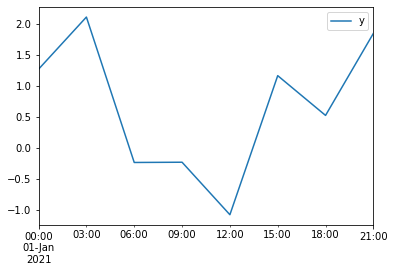

In [ ]:
# lets check for the first sample
pd.DataFrame({"y": to_np(ys[0].ravel())},index=index[0].ravel()).plot()

In [ ]:
#export
#hide
def _reshape_dataframe_to_timeseries_representation_different_lengths(df:pd.DataFrame, cont_names:list, 
                                         cat_names:list, y_names:list,
                                         ts_x_length:int, ts_y_length:int, 
                                        step_size:int, y_timeseries_offset:int):
    len_data = df.shape[0]
    has_cats = len(cat_names)>0
    max_samples = len_data - y_timeseries_offset - ts_y_length

    samples_tensor = max_samples // step_size + 1

    conts = torch.zeros((samples_tensor, len(cont_names), ts_x_length)).float()
    ys = torch.zeros((samples_tensor, len(cat_names), ts_y_length))
    indexes = np.zeros((samples_tensor, 1, ts_x_length), dtype='datetime64[s]')

    cats = None
    if has_cats:
        cats = torch.zeros((samples_tensor, len(cat_names), ts_x_length)).long()
    else:
        cats = torch.empty(((samples_tensor, len(cat_names), ts_x_length)))

    for sample_id, i in enumerate(range(0, max_samples + 1, step_size)):
        start_x = i
        end_x = start_x + ts_x_length
        start_y = i + y_timeseries_offset
        end_y = start_y + ts_y_length

        conts[sample_id, :, :] = tensor(
            df[cont_names][start_x:end_x].values.transpose().reshape(-1, ts_x_length)
        )
        indexes[sample_id, :, :] = df.index[start_x:end_x].values.transpose().reshape(-1, ts_x_length)
        
        if has_cats:
            cats[sample_id, :, :] = tensor(
                df[cat_names][start_x:end_x]
                .values.transpose()
                .reshape(-1, ts_x_length)
            ).long()

        ys[sample_id, :, :] = tensor(
            df[y_names].iloc[start_y:end_y]
            .values.transpose()
            .reshape(-1, ts_y_length)
        )

    return indexes, cats, conts, ys

The following function does the same as `convert_to_timeseries_representation`, however, it allows for more flexible reshaping. At the same time this function is slower for larger datasets.

In [ ]:
#export
def convert_to_timeseries_representation_different_lengths(to:TabularRenewables, 
                                                           ts_x_length:int, 
                                                           ts_y_length:int, 
                                                           step_size:int, 
                                                           y_timeseries_offset:int):
    """Converts a tabular renewables to a timeseries representation of [n_samples, timeseries length, number features].
    ts_x_length: The length of the input timeseries.
    ts_y_length: The length of the output timeseries.
    step_size: The shift for the output. Similar to a sliding window. 
    y_timeseries_offset: The (initial) offset of the output compared to the input."""
    
    indexes, cats, conts, ys= L(), L(), L(), L()
    has_cats = len(to.cat_names) > 0
    for task_id, df in to.items.groupby(to.group_id):
        df = df.sort_index()
        index, cat, cont, y = _reshape_dataframe_to_timeseries_representation_different_lengths(df,  
                                                            cont_names=to.cont_names, 
                                                            cat_names=to.cat_names, 
                                                            y_names=to.y_names, 
                                                            ts_x_length=ts_x_length, 
                                                            ts_y_length=ts_y_length, 
                                                            step_size=step_size, 
                                                            y_timeseries_offset=y_timeseries_offset)
        conts += cont
        ys += y
        indexes += index
        if has_cats:
            cats += cat
    indexes, cats, conts, ys = np.concatenate(indexes), torch.cat(list(cats)), torch.cat(list(conts)), torch.cat(list(ys))
    cats, conts, ys = _correct_types(to, cats, conts, ys)
    
    return indexes, cats, conts, ys
    


In [ ]:
show_doc(convert_to_timeseries_representation_different_lengths)

<h4 id="convert_to_timeseries_representation_different_lengths" class="doc_header"><code>convert_to_timeseries_representation_different_lengths</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>convert_to_timeseries_representation_different_lengths</code>(**`to`**:[`TabularRenewables`](/fastrenewables/tabular.core.html#TabularRenewables), **`ts_x_length`**:`int`, **`ts_y_length`**:`int`, **`step_size`**:`int`, **`y_timeseries_offset`**:`int`)

Converts a tabular renewables to a timeseries representation of [n_samples, timeseries length, number features].
ts_x_length: The length of the input timeseries.
ts_y_length: The length of the output timeseries.
step_size: The shift for the output. Similar to a sliding window. 
y_timeseries_offset: The (initial) offset of the output compared to the input.

For instance if we want to forecast `y` based on the last four hours of `x`, for the next four hours, we can configure it as follows.

In [ ]:
ts_x_length=4
y_timeseries_offset = ts_x_length
ts_y_length=ts_x_length
step_size=ts_x_length

df = get_test_df()
indexes, cats, conts, ys = convert_to_timeseries_representation_different_lengths(to, 
                                                      ts_x_length=ts_x_length,
                                                      ts_y_length=ts_y_length,
                                                      step_size=step_size,
                                                      y_timeseries_offset=y_timeseries_offset)

In [ ]:
test_eq(df[["x1","x2"]][0:4].values, to_np(conts[0]).T)
test_eq(df[["x1","x2"]][4:8].values, to_np(conts[1]).T)
test_close(df[["y"]][4:8].values, to_np(ys[0]).T)
test_close(df[["y"]][8:12].values, to_np(ys[1]).T)

In [ ]:
# hide
n_samples_per_day = 24//3
y_timeseries_offset = 2
ts_y_length=n_samples_per_day-y_timeseries_offset
step_size=n_samples_per_day
df = get_test_df()
indexes, cats, conts, ys = convert_to_timeseries_representation_different_lengths(to, 
                                                      ts_x_length=n_samples_per_day,
                                                      ts_y_length=ts_y_length,
                                                      step_size=step_size,
                                                      y_timeseries_offset=y_timeseries_offset)
test_eq(first_day_as_tensor.T, conts[0])
# first element of y should be equal to the element by the offset in the dataframe
test_eq(df["y"][y_timeseries_offset], ys[0][0][0])
# for each sample of the time series we increase by the step size
test_eq(df["y"][y_timeseries_offset+step_size], ys[1][0][0])
# for each sample of the time series we increase by the step size
test_eq(df["y"][y_timeseries_offset+step_size], ys[1][0][0])
# where the length of this timeseries is given by ts_y_length
test_eq(df["y"][y_timeseries_offset+step_size+ts_y_length-1], ys[1][0][-1])
# as we reduced the length of y by the offset, the last element should still be the last element
test_eq(df["y"][-1], ys[-1][-1][-1])

# check correct reshape of indexes
test_eq(indexes[0,0,0], to.items.sort_index().index[0])
test_eq(indexes[-1,-1,-1], to.items.sort_index().index[-1])

In [ ]:
# hide

y_timeseries_offset = 1
ts_y_length = 1
ts_x_length = 2
step_size=2
df = get_test_df()
indexes, cats, conts, ys = convert_to_timeseries_representation_different_lengths(to, 
                                                      ts_x_length=ts_x_length,
                                                      ts_y_length=ts_y_length,
                                                      step_size=step_size,
                                                      y_timeseries_offset=y_timeseries_offset)
test_eq(df["y"][y_timeseries_offset], ys[0][0][0])
test_eq(df["y"][y_timeseries_offset+step_size], ys[1][0][0])
test_eq(df["y"][y_timeseries_offset+step_size], ys[1][0][0])
test_eq(df["y"][y_timeseries_offset+step_size+ts_y_length-1], ys[1][0][-1])

test_eq(indexes[0,0,0], to.items.sort_index().index[0])
test_eq(indexes[-1,-1,-1], to.items.sort_index().index[-1])

In [ ]:
#export
#hide
def _convert_tabular_pandas_to_timeseries(
        to, 
        ts_x_length=None, 
        ts_y_length=None, 
        step_size=None,
        y_timeseries_offset=0,
    ):
        timeseries_length = None
        if (ts_x_length == None) and (ts_y_length == None) and (step_size == None):
            timeseries_length = _get_samples_per_day_single_task(to)
            ts_x_length = timeseries_length
            ts_y_length = timeseries_length
            step_size = timeseries_length
        elif None in (ts_x_length, ts_y_length, step_size):
            raise ValueError("Either none or all values must be provided for (ts_x_length, ts_y_length, step_size)")
        
        len_data = len(to.xs)
        has_cats = len(to.cat_names) > 0
        n_conts, n_cats, n_ys = len(to.cont_names),  len(to.cat_names), len(to.y_names)
        
        if len_data % ts_x_length != 0:
            raise Exception("Length of data is not dividable by length of a timeseries sequence.")
        
        if (ts_x_length == ts_y_length == step_size) and (y_timeseries_offset==0) and timeseries_length is not None:
            indexes, cats, conts, ys = convert_to_timeseries_representation(to, timeseries_length)
        else:
            indexes, cats, conts, ys = convert_to_timeseries_representation_different_lengths(to, 
                                                ts_x_length=ts_x_length, 
                                                ts_y_length=ts_y_length,
                                                step_size=step_size, 
                                                y_timeseries_offset=y_timeseries_offset)
        ts_lengths = (ts_x_length, ts_y_length, step_size)
        return ts_lengths, indexes, cats, conts, ys

In [ ]:
# hide
to = get_test_tabular()
_, indexes_implicit, cats_implicit, conts_implicit, ys_implicit = _convert_tabular_pandas_to_timeseries(to)
_, indexes_explicit, cats_explicit, conts_explicit, ys_explicit = \
    _convert_tabular_pandas_to_timeseries(to, ts_x_length=8, ts_y_length=8, step_size=8)
    
# check whether correct values of dataframe are determined
test_eq(indexes_implicit.shape, indexes_explicit.shape)
test_eq(cats_implicit.shape, cats_explicit.shape)
test_eq(conts_implicit.shape, conts_explicit.shape)
test_eq(ys_implicit.shape, ys_explicit.shape)

In [ ]:
#export
#hide
def _check_categoricals(indexes, conts, cats, ys, batch_first=True, sequence_last=True):
    # If selected, drop all categorical columns which do not have a constant value for each time series
    # individually.
    if batch_first and sequence_last:
        for i in range(cats.shape[1]):
            keep_indexes = []
            for j in range(cats.shape[0]):
                if (cats[j, i, :] - cats[j, i, 0]).sum() == 0:
                    keep_indexes += [j]

            n_dropped = cats.shape[0] - len(keep_indexes)
            if n_dropped > 0:
                warnings.warn(
                    f"Dropped {n_dropped} elements due to inconsistent categoricals in a sequence."
                )
            conts = conts[keep_indexes, :, :]
            cats = cats[keep_indexes, :, :]
            ys = ys[keep_indexes, :, :]
            indexes = indexes[keep_indexes, :, :]
    else:
        raise NotImplementedError(
            f"Drop inconsistent categoricals is not implemented for batch_first {self.batch_first} and sequence_last {self.sequence_last}"
        )
    return indexes, cats, conts, ys

In [ ]:
# hide
to = get_test_tabular()
_, indexes, cats, conts, ys = _convert_tabular_pandas_to_timeseries(to)
# simulate that all catecoricals have the same value along the timerseries axis
cats = torch.ones_like(cats)
# fake two incorrect values
cats[0][0][1]=0
cats[-1][0][1]=3
indexes_checked, cats_checked, conts_checked, ys_checked = _check_categoricals(indexes, conts, cats, ys)
# check if two values have been removed in all input/output and catecoricals
test_eq(cats.shape[0]-2, cats_checked.shape[0])
test_eq(conts.shape[0]-2, conts_checked.shape[0])
test_eq(indexes.shape[0]-2, indexes_checked.shape[0])
test_eq(ys.shape[0]-2, ys_checked.shape[0])

<ipython-input-31-a3cc964b6bbb>:15: UserWarning: Dropped 2 elements due to inconsistent categoricals in a sequence.
  warnings.warn(


In [ ]:
#export
#hide
def _adjust_ts_and_batch(data, batch_first, sequence_last):
    """
    Swap the dimensions of the given Tensor.
    Parameters
    ----------
    data : pytorch.Tensor
        Three dimensional Tensor whose dimensions are to be swapped. Expectes data of the dimension (batch, features, sequence length).
    batch_first : bool
        determines whether the first dimension of the resulting Tensors should denote the batch.
    sequence_last : bool
        determines whether the last dimension of the resulting Tensors should denote the sequence length.

    Returns
    -------
    data : pytorch.Tensor
        input tensor with swapped dimensions.
    """

    if batch_first and sequence_last:
        # batch, feature, seq -> batch, seq, feature
        pass
    elif batch_first and not sequence_last:
        # batch, feature, seq -> batch, seq, feature
        data = data.permute(0, 2, 1)
    elif not batch_first and not sequence_last:
        # batch, feature, seq -> seq, batch, feature
        data = data.permute(2, 0, 1)

    return data


In [ ]:
#export
#hide
def _convert_to_batch_ts_feature_view(data, batch_first, sequence_last):
    """
    Converts the data to the followong dimension (batch, sequence length, features).

    Parameters
    ----------
    data : pytorch.Tensor
        three dimensional Tensor whose dimensions are to be swapped.
    batch_first : bool
        determines whether the first dimension of the resulting Tensors denotes the batch.
    sequence_last : bool
        determines whether the last dimension of the resulting Tensors denotes the sequence length.

    Returns
    -------
    data : pytorch.Tensor
        input tensor with dimensions to be swapped.
    """

    if batch_first and sequence_last:
        # batch, feature, seq -> batch, seq, feature
        data = data.permute(0, 2, 1)
    elif not batch_first and not sequence_last:
        # seq, batch, feature -> batch, seq, feature
        data = data.permute(1, 0, 2)
    elif not batch_first and sequence_last:
        # feature, batch, seq -> batch, seq, feature
        data = data.permute(1, 2, 0)

    return data

In [ ]:
#export
class Timeseries(Transform, FilteredBase):
    "A transform to convert a TabularRenewables object into a timerseries representation."
    def __init__(
        self,
        to: TabularRenewables,
        ts_x_length: int = None,
        ts_y_length: int = None,
        step_size:int = None, 
        y_timeseries_offset=0,
        batch_first: bool = True,
        sequence_last: bool = True,
        drop_inconsistent_cats: bool = True,
        splits=None,
        post_hooks=[],
        **kwargs
    ):
        """

        Parameters
        ----------
        to : TabularRenewables
            input dataset, has to be set up before.
        ts_x_length: The length of the input timeseries.
        ts_y_length: The length of the output timeseries.
        step_size: The shift for the output. Similar to a sliding window. 
        y_timeseries_offset: The (initial) offset of the output compared to the input.
        batch_first : bool
            determines whether the first dimension of the resulting Tensors denoted the batch.
        sequence_last : bool
            determines whether the last dimension of the resulting Tensors denoted the sequence length.
        post_hooks : Simple (custom) transforms applied after transformations of the dataset to a timeseries.
        """
        
        self.to = to
        self.has_cat = len(to.cat_names) > 0
        self.batch_first, self.sequence_last = batch_first, sequence_last
        
        if getattr(to, "splits", None) is not None:
            warnings.warn("Splitting in TabularRenewables is not supported. \
                          Otherwise a correct splitting for timeseries is not assured. \
                          Fallback to complete data.")
            
        
        ts_lengths, self.indexes, self.cats, self.conts, self.ys = _convert_tabular_pandas_to_timeseries(to, 
                                                                               ts_x_length=ts_x_length,
                                                                               ts_y_length = ts_y_length,
                                                                               step_size = step_size,
                                                                               y_timeseries_offset = y_timeseries_offset
                                                                              )
        self.ts_x_length, self.ts_y_length, self.step_size = ts_lengths
        self.y_timeseries_offset = y_timeseries_offset
        

        self._adjust_to_required_timeseries_representation()
        
        for post_hook in post_hooks:
            self.indexes, self.cats, self.conts, self.ys = post_hook(self.indexes, self.cats, self.conts, self.ys)
        
        if splits is None:
            self.split = range(0,len(self))
        else:
            # TODO: check if it is already an object?
            splits = splits(self)
            self.split = splits
            
        self.dataloaders = delegates(self._dl_type.__init__)(self.dataloaders)
        
        self._check_shape()

    def _adjust_to_required_timeseries_representation(self):
        self.indexes = _adjust_ts_and_batch(
            self.indexes, self.batch_first, self.sequence_last
        )
        self.conts = _adjust_ts_and_batch(
            self.conts, self.batch_first, self.sequence_last
        )
        self.ys = _adjust_ts_and_batch(
            self.ys, self.batch_first, self.sequence_last
        )
        
        if self.has_cat:
            self.cats = _adjust_ts_and_batch(
                self.cats, self.batch_first, self.sequence_last
            )
    
    def _check_shape(self):
        if not self.batch_first or not self.sequence_last:
            raise NotImplementedError

    @property
    def input_sequence_length(self):
        return self.conts.shape[-1]
        
    @property
    def output_sequence_length(self):
        return self.ys.shape[-1]
    
    @property
    def c(self):
        return self.to.c
    
    @property
    def loss_func(self):
        return self.to.loss_func
    
    @property
    def n_subsets(self):
        return len(self.split)
    
    # required for splitting of train and eval
    def subset(self, i): 
        # ToDo: index=None, batch_first=True, sequence_last=True
        if len(self.split) == 2:
            return TimeseriesDataset(self._data_by_split(self.split[i]), 
                                     self._all_names(), self.c, self.loss_func, getattr(self.to, "classes", None))
        elif i == 0:
            return TimeseriesDataset(self._data_by_split(self.split), 
                                     self._all_names(), self.c, self.loss_func, getattr(self.to, "classes", None))
        else:
            return None
        
    @property
    def train(self):
        return self.subset(0)
    
    @property
    def valid(self):
        return self.subset(1)
    
    def _data_by_split(self, split):
        if len(self.cats) == 0:
            cats = []
        else:
            cats = self.cats[split]
            
        return (self.indexes[split], cats, self.conts[split], self.ys[split])
    
    def _data_by_id(self, i:int):
        return (self.indexes[i], self.cats[i], self.conts[i], self.ys[i])
    
    def _all_names(self):
        return (self.cat_names, self.cont_names, self.y_names)
    
    @property
    def cont_names(self):
        return self.to.cont_names
    
    @property
    def cat_names(self):
        return self.to.cat_names
    
    @property
    def y_names(self):
        return self.to.y_names
    
    def __len__(self):
        """
        Return the length of the used TabularPandas.

        Returns
        -------
        integer
            amount of lines in the TabularPandas
        """
        # TODO depends on position of batch
        return self.conts.shape[0]

    def show(self, max_n=10, **kwargs):
        """
        Create a plot for a 'max_n' of input- and target time series.
        Parameters
        ----------
        max_n : interger
            amount of samples that are to be plotted.
        kwargs

        Returns
        -------

        """
        # TODO: make subplots with grid
        tmp_data = Transform._adjust_ts_and_batch(
            self.xs, batch_first=True, sequence_last=True
        )

        for idx in range(self.xs.shape[1]):
            plt.plot(self.xs[0:max_n, idx, :].reshape(-1, 1))
            plt.title(f"Feature {self.tp.cont_names[idx]}")
            plt.show()

        for idx in range(self.ys.shape[1]):
            plt.plot(self.ys[0:max_n, idx, :].reshape(-1, 1))
            plt.title(f"Target {self.tp.y_names[idx]}")
            plt.show()

    def _all_names(self):
        return [self.to.cat_names, self.to.cont_names, self.to.y_names]
    


The `Timeseries` transform wraps a number of functions allowing to transform a `TabularRenewables` into a timeseries reporesentation. At the same time it allows to access all the required information of the tabular data.

In [ ]:
to = get_test_tabular()
tt = Timeseries(to)

By default it takes the number of samples per day for the timeseries length, as it is common for wind power prediction.

In [ ]:
# number of samples X number of features X timeseries length
tt.conts.shape

torch.Size([12, 2, 8])

<AxesSubplot:>

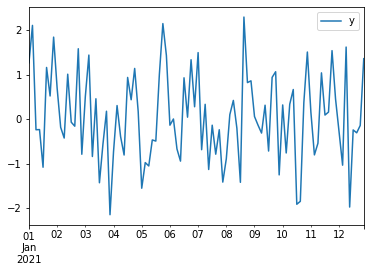

In [ ]:
pd.DataFrame({"y": to_np(tt.ys.reshape(-1))},index=tt.indexes.reshape(-1), columns=tt.y_names).plot()

In [ ]:
show_doc(Timeseries)

<h2 id="Timeseries" class="doc_header"><code>class</code> <code>Timeseries</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>Timeseries</code>(**`to`**:[`TabularRenewables`](/fastrenewables/tabular.core.html#TabularRenewables), **`ts_x_length`**:`int`=*`None`*, **`ts_y_length`**:`int`=*`None`*, **`step_size`**:`int`=*`None`*, **`y_timeseries_offset`**=*`0`*, **`batch_first`**:`bool`=*`True`*, **`sequence_last`**:`bool`=*`True`*, **`drop_inconsistent_cats`**:`bool`=*`True`*, **`splits`**=*`None`*, **`post_hooks`**=*`[]`*, **\*\*`kwargs`**) :: `Transform`

A transform to convert a TabularRenewables object into a timerseries representation.

In [ ]:
#export
class TimeseriesDataset(fastuple):
    "A dataset from a `Timeseries` object"
    def __init__(self, data:Timeseries, names:tuple, output_dim:int, loss_func, 
                 classes=None, index=None, batch_first=True, sequence_last=True):
        
        self.indexes, self.cats, self.conts, self.ys = data
        self.cat_names, self.cont_names, self.y_names = names
        self.classes = classes
        self.c = output_dim
        self.loss_func = loss_func
        
        if not batch_first or not sequence_last:
            raise NotImplementedError

    def __getitem__(self, idx):
        if len(self.cats) == 0:
            cats = []
        else:
            cats = self.cats[idx]

        return cats, self.conts[idx], self.ys[idx]

    def __len__(self): return len(self.conts)
    
    def new_empty(self):
        return TimeseriesDataset((np.empty(0), torch.empty(0), torch.empty(0), torch.empty(0)), [[], [], []], None, None)
    
    @property
    def input_sequence_length(self):
        return self.conts.shape[-1]
        
    @property
    def output_sequence_length(self):
        return self.ys.shape[-1]
    
    def as_df(self, max_n=-1):
        
        df_cont = pd.DataFrame(data=torch.swapaxes(self.conts[:max_n], 1, 2).reshape(-1,self.conts.shape[1]), columns=self.cont_names)
        df_cat = pd.DataFrame(data=torch.swapaxes(self.cats[:max_n], 1, 2).reshape(-1,self.cats.shape[1]), columns=self.cat_names)
        df_y = pd.DataFrame(data=torch.swapaxes(self.ys[:max_n], 1, 2).reshape(-1,self.ys.shape[1]), columns=self.y_names)
        df_all = pd.concat([df_cont, df_cat, df_y], axis=1)
        df_all.set_index(self.indexes[:max_n,:,:].reshape(-1), inplace=True)
        
        return df_all
    
    def __repr__(self):
        represenation = f"index:\n {self.indexes}\n{self.cat_names}:\n{self.cats}\n\n{self.cont_names}:\n{self.conts}\n\n{self.y_names}:\n{self.ys}\n\n"
        return represenation
    
    def show(self, max_n=10, **kwargs): 
        display_df(self.as_df(max_n))
        
    def show_batch(self, max_n=10, **kwargs): 
        self.show()

A `TimeseriesDataset` holds transformed information from a `Timeseries` transform as tensor. It also gives the possibility to convert the data to a dataframe.

In [ ]:
# get the training data
td = tt.train
type(td)

__main__.TimeseriesDataset

In [ ]:
#hide
td.new_empty() # check that this works for storing of a learner

index:
 []
[]:
tensor([])

[]:
tensor([])

[]:
tensor([])


In [ ]:
type(td.indexes), type(td.conts), type(td.cats), type(td.ys)

(numpy.ndarray, torch.Tensor, torch.Tensor, torch.Tensor)

In [ ]:
#export
class TimeSeriesDataLoader(DataLoader):
    "A dataloader for timersiers datasets."
    def __init__(self, dataset, bs=32, num_workers=0, device='cuda', 
                 to_device=True, shuffle=False, drop_last=True,**kwargs):
        "A `DataLoader` based on a `TabDataset"
        device = device if torch.cuda.is_available() else "cpu"
        
        super().__init__(dataset, bs=bs, num_workers=num_workers, shuffle=shuffle, 
                         device=device, drop_last=drop_last, **kwargs)
        
        self.dataset.bs=bs
        if to_device:self.to_device()
    
    def create_item(self, s): return s
    
    @property
    def input_sequence_length(self):
        return self.dataset.input_sequence_length
        
    @property
    def output_sequence_length(self):
        return self.dataset.output_sequence_length
    
    def to_device(self, device=None):
        if device is None: device = self.device
        self.dataset.cats.to(device)
        self.dataset.conts.to(device)
        self.dataset.ys.to(device)
    
    def create_batch(self, b):
        "Create a batch of data"
        cat, cont, y = self.dataset[b]
        return cat.to(self.device), cont.to(self.device), y.to(self.device)

    def get_idxs(self):
        "Get index's to select"
        idxs = Inf.count if self.indexed else Inf.nones
        if self.n is not None: idxs = list(range(len(self.dataset)))
        return idxs

    def shuffle_fn(self):
        "Shuffle the interior dataset"
        rng = np.random.permutation(len(self.dataset))
        self.dataset.cats = self.dataset.cats[rng]
        self.dataset.conts = self.dataset.conts[rng]
        self.dataset.ys = self.dataset.ys[rng]

In [ ]:
#export
class TimeSeriesDataLoaders(DataLoaders):
    "Dataloader container to store the training as well as the validation dataloader."
    def __init__(self, to, bs=64, val_bs=None, shuffle_train=True, device='cpu', **kwargs):
        if isinstance(to, Timeseries):
            train_ds = to.train
            valid_ds = to.valid
        else:
            train_ds = to
            valid_ds = to.new_empty()

            
        val_bs = bs if val_bs is None else val_bs
        train = TimeSeriesDataLoader(train_ds, bs=bs, shuffle=shuffle_train, device=device, **kwargs)
        valid = TimeSeriesDataLoader(valid_ds, bs=val_bs, shuffle=False, device=device, **kwargs)
        
        super().__init__(train, valid, device=device)
        
    @property
    def input_sequence_length(self):
        return self.train.input_sequence_length
        
    @property
    def output_sequence_length(self):
        return self.train.output_sequence_length

In [ ]:
Timeseries._dl_type = TimeSeriesDataLoader

In [ ]:
to = get_test_tabular(target="y", y_block=RegressionBlock())

With the `TimeSeriesDataLoaders` and `TimeSeriesDataLoader` the `Timeseries` transform can directly converted to dataloaders based on the training and validation split.

In [ ]:
tt = Timeseries(to, splits=RandomSplitter())

In [ ]:
type(tt)

__main__.Timeseries

In [ ]:
dl = tt.dataloaders(bs=4)

In [ ]:
r = dl.one_batch()

In [ ]:
dl.train_ds.show(1)

,x1,x2,cat,y
2021-01-09 00:00:00,32.0,15.5,1,0.061431
2021-01-09 03:00:00,32.5,15.0,4,-0.132878
2021-01-09 06:00:00,33.0,14.5,2,-0.310482
2021-01-09 09:00:00,33.5,14.0,1,0.315298
2021-01-09 12:00:00,34.0,13.5,1,-0.714177
2021-01-09 15:00:00,34.5,13.0,3,0.940126
2021-01-09 18:00:00,35.0,12.5,4,1.067317
2021-01-09 21:00:00,35.5,12.0,1,-1.249887


In [ ]:
dls = TimeSeriesDataLoaders(tt)

In [ ]:
dl = TimeSeriesDataLoader(tt.train, bs=2)
cats,conts, ys = dl.one_batch()

In [ ]:
dl = TimeSeriesDataLoader(tt.valid, bs=2, shuffle=True)
cats,conts, ys = dl.one_batch()

In case the `Timeseries` transform is insufficient for you needs, we provide the possibility utilize hooks, that can be applied after the initial tranformation. For example consider the case, when we want to forecast a category, that is the same with a time.

Note: For classification we require a `CategoryBlock` instead of `RegressionBlock`, similar to a `TabularPandas`.

In [ ]:
to = get_test_tabular(target="TID", y_block=CategoryBlock())

In [ ]:
to.items.sort_index()

,x1,x2,cat,TID,y
2021-01-01 00:00:00,0.0,47.5,2,0,1.267518
2021-01-01 03:00:00,0.5,47.0,4,0,2.107840
2021-01-01 06:00:00,1.0,46.5,2,0,-0.236089
2021-01-01 09:00:00,1.5,46.0,1,0,-0.232082
2021-01-01 12:00:00,2.0,45.5,3,0,-1.078139
...,...,...,...,...,...
2021-01-12 09:00:00,45.5,2.0,3,1,-1.972457
2021-01-12 12:00:00,46.0,1.5,1,1,-0.240680
2021-01-12 15:00:00,46.5,1.0,2,1,-0.304481
2021-01-12 18:00:00,47.0,0.5,3,1,-0.139733


In [ ]:
to = get_test_tabular(target="TID", y_block=CategoryBlock())
tt = Timeseries(to, splits=RandomSplitter(), post_hooks=[])

In this case a simple transform leads to the same value for a day.

In [ ]:
tt.ys.shape

torch.Size([12, 1, 8])

In [ ]:
tt.ys

tensor([[[0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0]],

        [[1, 1, 1, 1, 1, 1, 1, 1]],

        [[1, 1, 1, 1, 1, 1, 1, 1]]])

However, for classification it might be sufficient to forecast a single value for the timeseries. By applying `post_hooks`, we can achieve the required representation.

In [ ]:
#export
def reduce_target_timeseries_to_element(indexes, cats, conts, ys, element_pos=0):
    "Simple transform to shorten the target timeseries."
    ys = ys[:,:,element_pos].reshape(-1,1,1)
    
    return indexes, cats, conts, ys

In [ ]:
# check the number of classes
test_eq(2, tt.c)

In [ ]:
to = get_test_tabular(target="TID", y_block=CategoryBlock())
tt = Timeseries(to, post_hooks=[partial(reduce_target_timeseries_to_element, element_pos=0)])

In [ ]:
tt.ys

tensor([[[0]],

        [[0]],

        [[0]],

        [[0]],

        [[0]],

        [[0]],

        [[0]],

        [[0]],

        [[0]],

        [[0]],

        [[1]],

        [[1]]])